# Experiments with kernel machines

In this notebook we use various two-dimensional data set to compare and contrast the kernel perceptron and supported vector machine methods for constructing the decision boundaries. The latter is based on the implementation from the Scikit-learn library.

## Load libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

## The kernel Perceptron

The kernel Perceptron algorithm built in this notebook allows for the quadratic and RBF kernels. The main method is the `learn_and_display_Perceptron(datafile, kernel_type, s_value)` while the others are auxiliary functions.

In [42]:
### 
### Auxiliary functions
###


def compute_WdotPhi_quad(alpha, x, y, x_i):
    ## Computes the dot product of W.Phi for the quadratic kernel function
    n, d = x.shape
    
    wdotphi = sum(alpha*y*(1+np.dot(x[:,:],x_i))*(1+np.dot(x[:,:],x_i)))

    return wdotphi

def compute_WdotPhi_rbf(alpha, x, y, x_i, s_value):
    ## Computes the dot product of W.Phi for the rbf kernel
    n, d = x.shape
    #print(n, d)
    wdotphi = 0
    xvalues = np.array([np.linalg.norm(x[j]-x_i) for j in range(len(x))])
    Exp = np.array([np.exp(-xvalues[j]**2/s_value**2) for j in range(len(xvalues))])
    wdotphi = sum(alpha*y*Exp)
    return wdotphi

def evaluate_kernel_classifier(WdotPhi,b):
    if (WdotPhi + b) > 0:
        return 1
    if (WdotPhi + b) <= 0:
        return -1
    return 0

def kernel_perceptron_quadratic(x, y, n_iters=100):
    # Performs perceptron algorithm in dual form for the quadratic kernel
    n, d = x.shape
    b = 0;
    alpha = np.zeros(len(y))
    done = False
    converged = True
    iters=0
    while not(done):
        done = True;
        I = np.random.permutation(n)
        for i in range(n):
            j = I[i]
            xvalues = np.array([(1+x[i].dot(x[j]))*(1+x[i].dot(x[j])) for i in range(len(x))])
            WdotPhi = sum(alpha*y*xvalues)
            if (evaluate_kernel_classifier(WdotPhi, b) != y[j]):
                alpha[j] = alpha[j] + 1
                b = b + y[j]
                done = False
        iters = iters + 1
        if iters > n_iters:
            done = True
            converged = False
    
    return alpha, b, converged

def kernel_perceptron_rbf(x, y, s_value, n_iters=100):
    # Performs perceptron algorithm in dual form for the rbf kernel
    ## TODO: optimize method
    n, d = x.shape
    b = 0;
    alpha = np.zeros(len(y))
    done = False
    converged = True
    iters=0
    while not(done):
        done = True;
        I = np.random.permutation(n)
        for i in range(n):
            j = I[i]
            WdotPhi = compute_WdotPhi_rbf(alpha, x, y, x[j,:], s_value)
            if (evaluate_kernel_classifier(WdotPhi, b) != y[j]):
                alpha[j] = alpha[j] + 1
                b = b + y[j]
                done = False
        iters = iters + 1
        if iters > n_iters:
            done = True
            converged = False
    
    return alpha, b, converged

###--------------------------
### MAIN PERCEPTRON METHOD
###--------------------------

def learn_and_display_Perceptron(datafile, kernel_type, s_value=5.93):
    data = np.loadtxt(datafile)
    n,d = data.shape
    # Create training set x and labels y
    x = data[:,0:2]
    y = data[:,2]
    # Now train a support vector machine and identify the support vectors
    if kernel_type == 'quadratic':
        alpha, b, converged = kernel_perceptron_quadratic(x, y)
    if kernel_type == 'rbf':
        alpha, b, converged = kernel_perceptron_rbf(x, y, s_value)
        
    # Determine the x1- and x2- limits of the plot
    x1min = min(x[:,0]) - 1
    x1max = max(x[:,0]) + 1
    x2min = min(x[:,1]) - 1
    x2max = max(x[:,1]) + 1
    plt.xlim(x1min,x1max)
    plt.ylim(x2min,x2max)
    # Plot the data points
    plt.plot(x[(y==1),0], x[(y==1),1], 'rD')
    plt.plot(x[(y==-1),0], x[(y==-1),1], 'k^')
    # Construct a grid of points at which to evaluate the classifier
    if converged:
        grid_spacing = 0.05
        xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, grid_spacing), np.arange(x2min, x2max, grid_spacing))
        grid = np.c_[xx1.ravel(), xx2.ravel()]
        #print(grid[0], x[1,:])
        if kernel_type == 'quadratic':
            WdotPhiArray = np.array([compute_WdotPhi_quad(alpha, x, y, pt) for pt in grid])
        if kernel_type == 'rbf':
            WdotPhiArray = np.array([compute_WdotPhi_rbf(alpha, x, y, pt, s_value) for pt in grid])
        Z = np.array([evaluate_kernel_classifier(WdotPhi,b) for WdotPhi in WdotPhiArray])
        # Show the classifier's boundary using a color plot
        Z = Z.reshape(xx1.shape)
        plt.pcolormesh(xx1, xx2, Z, cmap=plt.cm.RdBu, vmin=-2, vmax=2)
    plt.show()                               

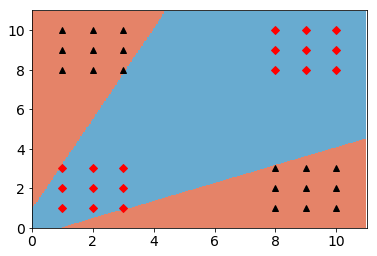

In [43]:
learn_and_display_Perceptron('data2.txt', kernel_type='quadratic')

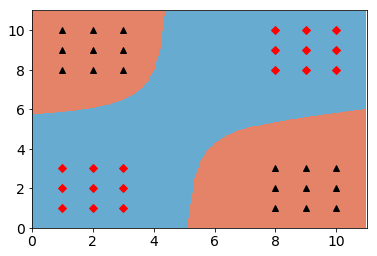

In [44]:
learn_and_display_Perceptron('data2.txt', kernel_type='rbf')

## The kernel SVM

In [26]:
def learn_and_display_SVM(datafile, kernel_type='rbf', C_value=1.0, s_value=1.0):
    data = np.loadtxt(datafile)
    n,d = data.shape
    # Create training set x and labels y
    x = data[:,0:2]
    y = data[:,2]
    # Now train a support vector machine and identify the support vectors
    if kernel_type == 'rbf':
        clf = SVC(kernel='rbf', C=C_value, gamma=1.0/(s_value*s_value))
    if kernel_type == 'quadratic':
        clf = SVC(kernel='poly', degree=2, C=C_value, coef0=1.0)
    clf.fit(x,y)
    sv = np.zeros(n,dtype=bool)
    sv[clf.support_] = True
    notsv = np.logical_not(sv)
    # Determine the x1- and x2- limits of the plot
    x1min = min(x[:,0]) - 1
    x1max = max(x[:,0]) + 1
    x2min = min(x[:,1]) - 1
    x2max = max(x[:,1]) + 1
    plt.xlim(x1min,x1max)
    plt.ylim(x2min,x2max)
    # Plot the data points, enlarging those that are support vectors
    plt.plot(x[(y==1)*notsv,0], x[(y==1)*notsv,1], 'rD')
    plt.plot(x[(y==1)*sv,0], x[(y==1)*sv,1], 'rD', markersize=10)
    plt.plot(x[(y==-1)*notsv,0], x[(y==-1)*notsv,1], 'k^')
    plt.plot(x[(y==-1)*sv,0], x[(y==-1)*sv,1], 'k^', markersize=10)
    # Construct a grid of points and evaluate classifier at each grid points
    grid_spacing = 0.05
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, grid_spacing), np.arange(x2min, x2max, grid_spacing))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    Z = clf.decision_function(grid)
    # Quantize the values to -1, -0.5, 0, 0.5, 1 for display purposes
    for i in range(len(Z)):
        Z[i] = min(Z[i],1.0)
        Z[i] = max(Z[i],-1.0)
        if (Z[i] > 0.0) and (Z[i] < 1.0):
            Z[i] = 0.5
        if (Z[i] < 0.0) and (Z[i] > -1.0):
            Z[i] = -0.5
    # Show boundary and margin using a color plot
    Z = Z.reshape(xx1.shape)
    plt.pcolormesh(xx1, xx2, Z, cmap=plt.cm.RdBu, vmin=-2, vmax=2)
    plt.show()

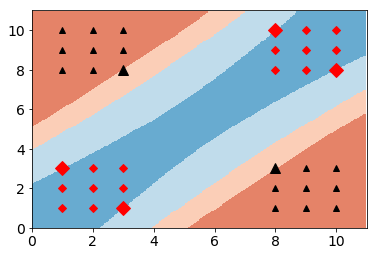

In [27]:
learn_and_display_SVM('data2.txt', 'quadratic', 1.0)

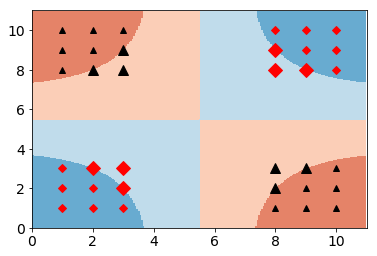

In [28]:
learn_and_display_SVM('data2.txt', 'rbf', 10.0, 10.0)